# Colorizing B&W Photos 

Welcome to the world of photo colorization! In this project, we have developed a powerful machine learning model that is capable of transforming black and white photos into vibrant and realistic color images. Leveraging the cutting-edge techniques of deep learning, our model is built upon an intricate architecture comprising an encoder, classification layer, a fusion layer and a decoder.


> **Importing useful Modules**

In [2]:
import os
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, RepeatVector
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import gray2rgb, rgb2gray, rgb2lab, lab2rgb
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
import matplotlib.pyplot as plt

> **Importing Training Images**

I will be using only 20 color (RGB) images to train our model due to computational resources. The cell below convert the images into numpy array with values between 0 to 1 (RGB channel have 0-255 numbers for each color channel)

In [3]:
# Get images
X = []
for filename in os.listdir('/kaggle/input/image-colorization-dataset/data/train_color')[:20]:
    X.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/train_color/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [4]:
Xtrain.shape

(20, 400, 400, 3)

we have 20 color images each of size **400 x 400** with 3 channels.

> **Model Architecture**

The colorization neural model can be divided into four compononts.
1. **Encoder** :  This extracts intricate features from black and white images. This encoding process captures essential details and patterns.
2. **Classifier** : This layer enables the model to understand and distinguish various objects, scenes, and elements within the image.
3. **Fusion Layer** :  This layer integrates features extracted by the encoder with classifier's output, which enhances the colorization results.
4. **Decoder** : It takes the encoded features and transforms them into a high-resolution color image. 

For Classification part, I will be using InceptionResNetV2 Model which is trained on more than a million images from the **ImageNet database**. The network is **164 layers deep** and can classify images into **1000 object** categories

In [5]:
#Loading pre-trained InceptionResNetV2 
inception = InceptionResNetV2(include_top=True)

225209952/225209952 [==============================] - 1s 0us/step


The Image also runs through the below model architecture. The Output of the Encoder and inception part is concatenate (see the combination of 256 and 1000 in the below image)


![](http://blog.floydhub.com/content/images/2018/06/layer_including_fusion_layer.png)

In [6]:

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(400, 400, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(50 * 50)(embed_input) 
fusion_output = Reshape(([50, 50, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

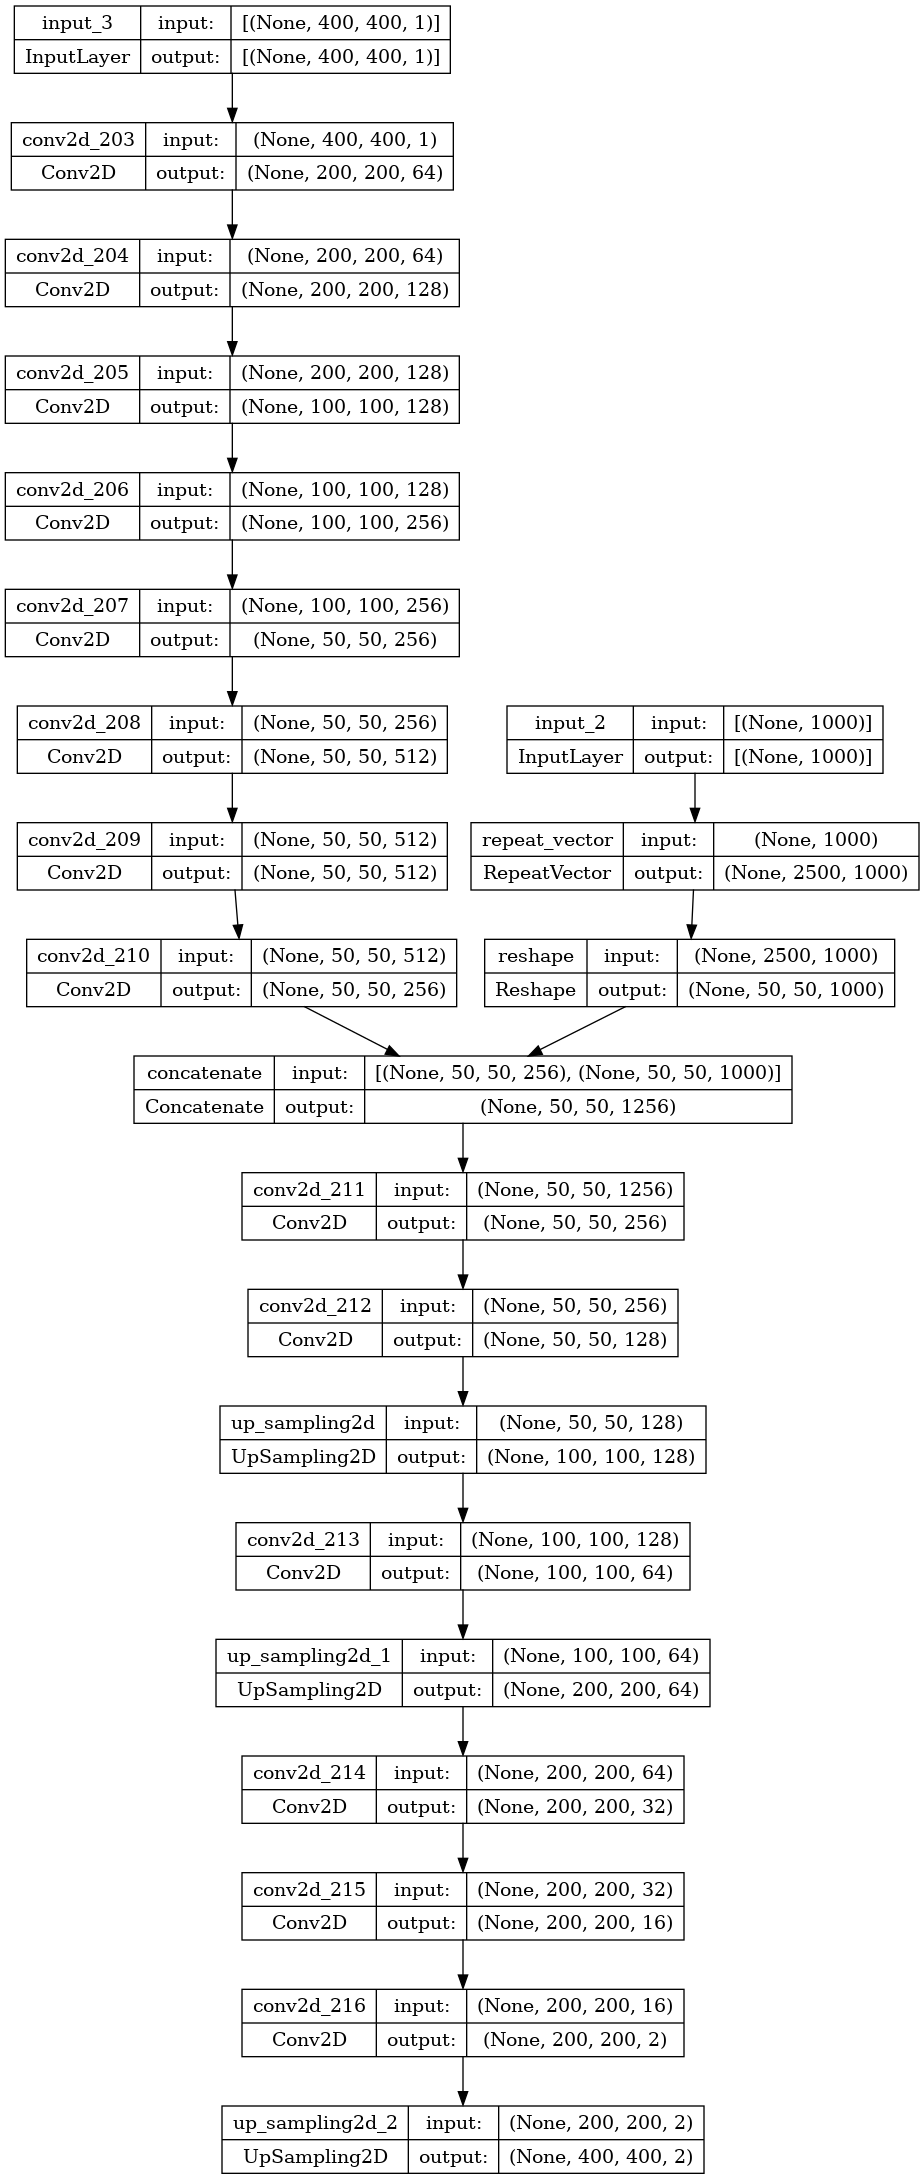

In [7]:
plot_model(model, show_shapes = True)

The architecture of above model is inspired from [here.](http://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/) Refer to the link above for more details.

> **Preparing Images for Training**

Below are the some steps to prepare data for training. Let me summarize it.
* **create_inception_embedding** resizes the grayscaled image into 299 x 299 (input for the inception model) and return embeddings.
* The function **image_a_b_gen** does two things, first it generates grayscale images from Colored RGB Images and and use it to create embeddings. Second, it converts RGB to LAB colorspace. Read more about it [here](http://en.wikipedia.org/wiki/CIELAB_color_space). 

**LAB** -  L stands for lightness, and a and b for the color spectrums green–red and blue–yellow.

As you can see below, a Lab encoded image has one layer for grayscale and have packed three color layers into two. This means that we can use the original grayscale image in our final prediction. Also, we only have to two channels to predict.

![](https://blog.floydhub.com/content/images/2018/06/woman_lab_color_space.png)

In [8]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

#Generate training data
batch_size = 20

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)



> **Training the Model**

In [ ]:
model.fit(image_a_b_gen(batch_size), epochs=1000, steps_per_epoch=1, verbose = 1)

In [ ]:
#saving the trained model
from tensorflow.keras.models import save_model
save_model(model,'/kaggle/working/Image_colorization_model.h5')

In [9]:
#loading the saved model
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/imagecolorization-trained-model/Image_colorization_model.h5')

> **Prediction**

we will be coloring 100 B&W images drom test-black dataset.

In [10]:
#Make a prediction on the unseen images
color_me = []
for filename in os.listdir('/kaggle/input/image-colorization-dataset/data/test_black/')[:100]:
    color_me.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/test_black/'+filename)))
#color_me.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/test_black/image5000.jpg')))
#color_me.append(img_to_array(load_img('/kaggle/input/image-colorization-dataset/data/test_black/image5001.jpg')))
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))




4/4 [==============================] - 18s 571ms/step


In [11]:
color_me.shape

(100, 400, 400, 1)

In [12]:
# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

4/4 [==============================] - 12s 698ms/step


In [13]:
os.makedirs('/kaggle/working/predicted')

In [17]:
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    plt.imsave("/kaggle/working/predicted/"+str(i)+".png", lab2rgb(cur))

/tmp/ipykernel_28/38169253.py:6: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 28 negative Z values that have been clipped to zero
  plt.imsave("/kaggle/working/predicted/"+str(i)+".png", lab2rgb(cur))
/tmp/ipykernel_28/38169253.py:6: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  plt.imsave("/kaggle/working/predicted/"+str(i)+".png", lab2rgb(cur))
/tmp/ipykernel_28/38169253.py:6: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  plt.imsave("/kaggle/working/predicted/"+str(i)+".png", lab2rgb(cur))
/tmp/ipykernel_28/38169253.py:6: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 218 negative Z values that have been clipped to zero
  plt.imsave("/kaggle/working/predicted/"+str(i)+".png", lab2rgb(cur))
/tmp/ipykernel_28/38169253.py:6: UserWarning: Conversion from CIE

# Seeing some coloring!

Most of the images turned out poor, but I managed to find a few decent ones. Seeing that the model is trained on only 20 images, I will consider them a good prediction.

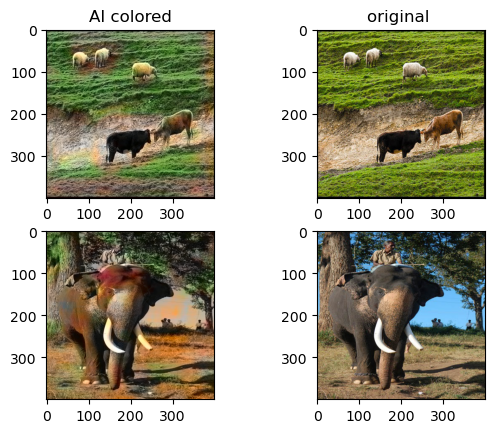

In [24]:
plt.figure()
plt.subplot(221,title = 'AI colored')
plt.imshow(load_img('/kaggle/working/predicted/14.png'))
plt.subplot(223)
plt.imshow(load_img('/kaggle/working/predicted/98.png'))
plt.subplot(222, title = 'original ')
plt.imshow(load_img('/kaggle/input/image-colorization-dataset/data/test_color/image5383.jpg'))
plt.subplot(224)
plt.imshow(load_img('/kaggle/input/image-colorization-dataset/data/test_color/image5118.jpg'))


# Conclusion

The primary goal of our project was to transform black and white images into vibrant, lifelike color representations while preserving the essence and context of the original scene.
It wasn't perfect though, I am still figuring out why the images turned out to be brownish why we train for large epoches. The InceptionResNetV2 is clearly doing its role by identifying objects like grass in above example.

Overall It was a great project to learn and improve myself.